# Gaussian Shells

This is a simple interactive version of the Gaussian Shells demo in the documentation.

## Setup

First, let's set up some environmental dependencies. These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

In [1]:
# Python 3 compatability
from __future__ import division, print_function
from builtins import range

# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np
import math
from numpy import linalg

# inline plotting
%matplotlib inline

# plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# seed the random number generator
np.random.seed(5)

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 30})

In [3]:
import dynesty

# 2-D Gaussian Shells

To demonstrate more of the functionality afforded by our different sampling/bounding options we will demonstrate how these various features work using a set of 2-D **Gaussian shells** with a uniform prior over $[-6, 6]$.

In [4]:
# defining constants
r = 2.  # radius
w = 0.1  # width
c1 = np.array([-3.5, 0.])  # center of shell 1
c2 = np.array([3.5, 0.])  # center of shell 2
const = math.log(1. / math.sqrt(2. * math.pi * w**2))  # normalization constant

# log-likelihood of a single shell
def logcirc(theta, c):
    d = np.sqrt(np.sum((theta - c)**2, axis=-1))  # |theta - c|
    return const - (d - r)**2 / (2. * w**2)

# log-likelihood of two shells
def loglike(theta):
    return np.logaddexp(logcirc(theta, c1), logcirc(theta, c2))

# our prior transform
def prior_transform(x):
    return 12. * x - 6.

In [5]:
# compute likelihood surface over a 2-D grid
xx, yy = np.meshgrid(np.linspace(-6., 6., 200), np.linspace(-6., 6., 200))
L = np.exp(loglike(np.dstack((xx, yy))))

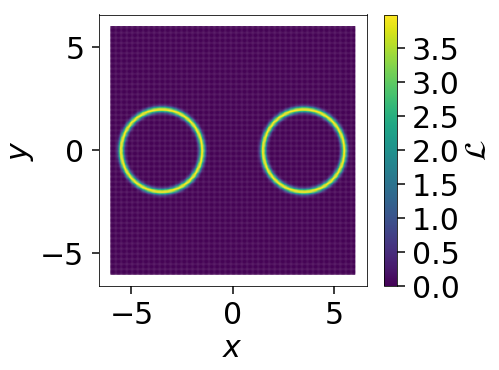

In [6]:
# plot result
fig = plt.figure(figsize=(6,5))
plt.scatter(xx, yy, c=L, s=0.5)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.colorbar(label=r'$\mathcal{L}$');

# Bounding Options

Let's test out our bounding options (with uniform sampling) on these 2-D shells. To illustrate their baseline effectiveness, we will also disable the initial delay before our first update.

In [7]:
# bounding methods
bounds = ['none', 'single', 'multi', 'balls', 'cubes']

# run over each method and collect our results
bounds_res = []
for b in bounds:
    sampler = dynesty.NestedSampler(loglike, prior_transform, ndim=2,
                                    bound=b, sample='unif', nlive=1000,
                                    first_update={'min_ncall': -np.inf,
                                                  'min_eff': np.inf})
    sys.stderr.flush()
    t0 = time.time()
    sampler.run_nested(dlogz=0.1)
    t1 = time.time()
    res = sampler.results
    res['time'] = t1 - t0
    sys.stderr.flush()
    sys.stderr.write('{0}s\n'.format(res['time']))
    bounds_res.append(sampler.results)

iter: 5477+1000 | bound: 1 | nc: 1 | ncall: 256453 | eff(%):  2.526 | loglstar:   -inf <  1.384 <    inf | logz: -1.738 +/-  0.048 | dlogz:  0.000 >  0.100            19.5403659344s
iter: 5561+1000 | bound: 117 | nc: 1 | ncall: 99674 | eff(%):  6.582 | loglstar:   -inf <  1.384 <    inf | logz: -1.822 +/-  0.049 | dlogz:  0.000 >  0.100            20.2487127781s
iter: 5455+1000 | bound: 49 | nc: 1 | ncall: 40062 | eff(%): 16.113 | loglstar:   -inf <  1.384 <    inf | logz: -1.716 +/-  0.048 | dlogz:  0.000 >  0.100            219.791846037s
iter: 5553+1000 | bound: 24 | nc: 1 | ncall: 20198 | eff(%): 32.444 | loglstar:   -inf <  1.384 <    inf | logz: -1.814 +/-  0.049 | dlogz:  0.000 >  0.100            277.40710187s
iter: 5444+1000 | bound: 27 | nc: 1 | ncall: 22526 | eff(%): 28.607 | loglstar:   -inf <  1.384 <    inf | logz: -1.705 +/-  0.048 | dlogz:  0.000 >  0.100            271.2707901s


We can see the amount of overhead associated with `'multi'`,`'cubes'`, and `'balls'` is non-trivial in this case. For `'multi'`, most of this overhead comes from the computational cost of *updating* our bounding distribution: multi-ellipsoidal decompositions are relatively expensive (especially given we repeat this process with bootstrap resampling to compute correction factors). For `'cubes'` and `'balls'`, on the other hand, the overhead mainly comes from *sampling* from our bouding distributions, since accepting or rejecting a point requires counting all neighbors within some radius $r$, leading to frequent nearest-neighbor searches. `dynesty` utilizes [KDTrees](https://en.wikipedia.org/wiki/K-d_tree) to help with these, adding some overhead but improving overall scaling.

Runtime aside, we see that each method runs for a similar number of iterations and give similar `logz` and `dlogz` values (with comparable errors). They thus appear to be unbiased both with respect to each other and with respect to the analytic solution ($\ln \mathcal{Z} = -1.75$).

To get a sense of what each of our bounds looks like, we can use some of `dynesty`'s built-in plotting functionality. First, let's take a look at the case where we had no bounds (`'none'`).

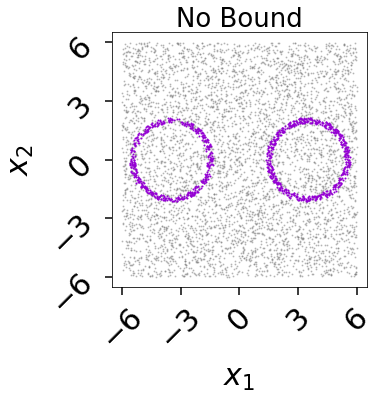

In [8]:
from dynesty import plotting as dyplot

# initialize figure
fig, axes = plt.subplots(1, 1, figsize=(6, 6))

# plot proposals in corner format for 'none'
fg, ax = dyplot.cornerbound(bounds_res[0], it=3000, prior_transform=prior_transform,
                            show_live=True, fig=(fig, axes))
ax[0, 0].set_title('No Bound', fontsize=26)
ax[0, 0].set_xlim([-6.5, 6.5])
ax[0, 0].set_ylim([-6.5, 6.5]);

Now let's examine the single and multi-ellipsoidal cases.

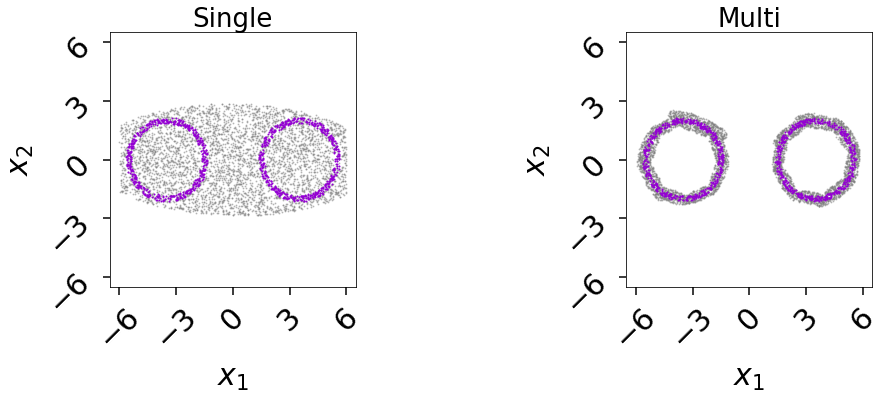

In [9]:
# initialize figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes = axes.reshape((1, 3))
[a.set_frame_on(False) for a in axes[:, 1]]
[a.set_xticks([]) for a in axes[:, 1]]
[a.set_yticks([]) for a in axes[:, 1]]

# plot proposals in corner format for 'single'
fg, ax = dyplot.cornerbound(bounds_res[1], it=3000, prior_transform=prior_transform,
                            show_live=True, fig=(fig, axes[:, 0]))
ax[0, 0].set_title('Single', fontsize=26)
ax[0, 0].set_xlim([-6.5, 6.5])
ax[0, 0].set_ylim([-6.5, 6.5])

# plot proposals in corner format for 'multi'
fg, ax = dyplot.cornerbound(bounds_res[2], it=3000, prior_transform=prior_transform,
                            show_live=True, fig=(fig, axes[:, 2]))
ax[0, 0].set_title('Multi', fontsize=26)
ax[0, 0].set_xlim([-6.5, 6.5])
ax[0, 0].set_ylim([-6.5, 6.5]);

Finally, let's take a look at our overlapping set of balls and cubes.

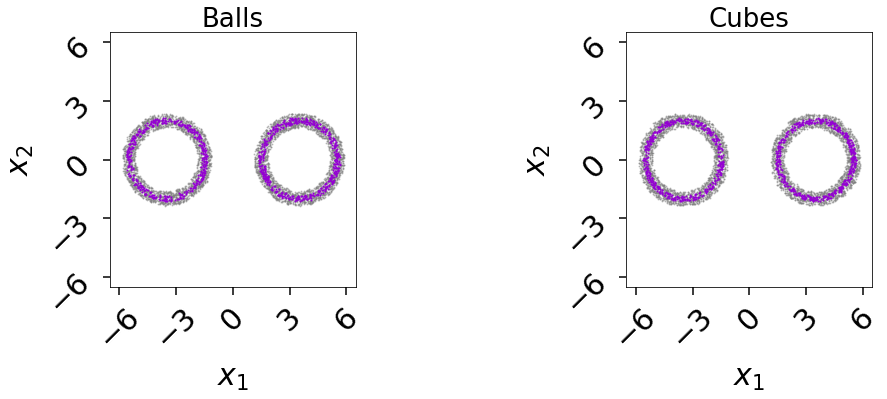

In [10]:
# initialize figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes = axes.reshape((1, 3))
[a.set_frame_on(False) for a in axes[:, 1]]
[a.set_xticks([]) for a in axes[:, 1]]
[a.set_yticks([]) for a in axes[:, 1]]

# plot proposals in corner format for 'balls'
fg, ax = dyplot.cornerbound(bounds_res[3], it=3000, prior_transform=prior_transform,
                            show_live=True, fig=(fig, axes[:, 0]))
ax[0, 0].set_title('Balls', fontsize=26)
ax[0, 0].set_xlim([-6.5, 6.5])
ax[0, 0].set_ylim([-6.5, 6.5])

# plot proposals in corner format for 'cubes'
fg, ax = dyplot.cornerbound(bounds_res[4], it=3000, prior_transform=prior_transform,
                            show_live=True, fig=(fig, axes[:, 2]))
ax[0, 0].set_title('Cubes', fontsize=26)
ax[0, 0].set_xlim([-6.5, 6.5])
ax[0, 0].set_ylim([-6.5, 6.5]);

# Bounding Objects

By default, the nested samplers in `dynesty` save all bounding distributions used throughout the course of a run, which can be accessed within the `results` dictionary. More information on these distributions can be found in `bounding.py`.

In [11]:
# the proposals associated with our 'multi' bounds
bounds_res[2].bound

Each bounding object has a host of additional functionality that the user can experiment with. For instance, the volume contained by the *union* of ellipsoids within `MultiEllipsoid` can be estimated using **Monte Carlo integration** (but otherwise are not computed by default). These volume estimates, combined with what fraction of our samples overlap with the unit cube (since our bounding distributions can exceed our prior bounds), can give us an idea of how effectively our multi-ellipsoid bounds are shrinking over time compared with the single-ellipsoid case.

In [12]:
# compute effective 'single' volumes
single_vols = [1.]  # unit cube
for bound in bounds_res[1].bound[1:]:
    vol = bound.vol  # volume
    funit = bound.unitcube_overlap() # fractional overlap with unit cube
    single_vols.append(vol * funit)
single_vols = np.array(single_vols)

# compute effective 'multi' volumes
multi_vols = [1.]  # unit cube
for bound in bounds_res[2].bound[1:]:  # skip unit cube
    vol, funit = bound.monte_carlo_vol(return_overlap=True)
    multi_vols.append(vol * funit)  # numerical estimate via Monte Carlo methods
multi_vols = np.array(multi_vols)

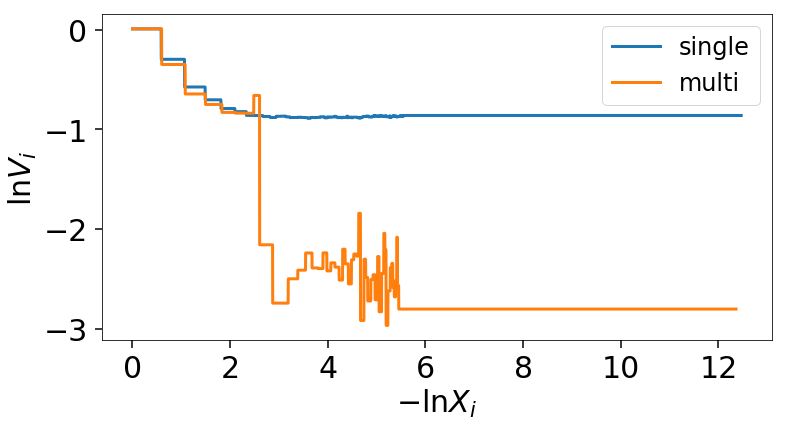

In [13]:
# plot results as a function of ln(volume)
plt.figure(figsize=(12,6))
plt.xlabel(r'$-\ln X_i$')
plt.ylabel(r'$\ln V_i$')

# 'single'
res = bounds_res[1]
x = -res.logvol  # ln(prior volume)
it = res.bound_iter  # proposal idx at given iteration
y = np.log(single_vols[it])  # corresponding ln(bounding volume)
plt.plot(x, y, lw=3, label='single')

# 'multi'
res = bounds_res[2]
x, it = -res.logvol, res.bound_iter
y = np.log(multi_vols[it])
plt.plot(x, y, lw=3, label='multi')
plt.legend(loc='best', fontsize=24);

We see that in the beginning, only a single ellipsoid is used. After some bounding updates have been made, there is enough of an incentive to split the proposal into several ellipsoids. Although the initial ellipsoid decompositions can be somewhat unstable (i.e. bootstrapping can give relatively large volume expansion factors), over time this process leads to a significant decrease in effective overall volume. The process by which an ellipsoid is split into multiple ellipsoids can be tuned by the user using the `'vol_dec'` and `'vol_check'` keyword arguments.

# Sampling Options

Let's test out our sampling options (with `'multi'` bounding) on our 2-D shells defined above. A few small notes:
- Since non-uniform sampling is significantly less efficient relative to uniform sampling in lower dimensions, we'll increase `update_interval` to compensate in order to avoid excessive ellipsoid decompositions. 
- Bootstrapping (see below) is *disabled* by default when sampling using methods other than `'unif'` since sampling is only *conditioned* on the *shape* of the bounding distribution, not its absolute size. In cases where the bounding distribution is complex (such as this one), this can significantly cut down on computational overhead.

In [14]:
# bounding methods
sampling = ['unif', 'rwalk', 'slice', 'rslice', 'hslice']
updating = [1.5, 2., 5., 2., 15.]

# run over each method and collect our results
sampling_res = []
for s, u in zip(sampling, updating):
    sampler = dynesty.NestedSampler(loglike, prior_transform, ndim=2,
                                    bound='multi', sample=s, nlive=1000,
                                    update_interval=u)
    sys.stderr.flush()
    t0 = time.time()
    sampler.run_nested(dlogz=0.1)
    t1 = time.time()
    res = sampler.results
    res['time'] = t1 - t0
    sys.stderr.flush()
    sys.stderr.write('{0}s\n'.format(res['time']))
    sampling_res.append(sampler.results)

iter: 5549+1000 | bound: 22 | nc: 1 | ncall: 68928 | eff(%):  9.501 | loglstar:   -inf <  1.384 <    inf | logz: -1.810 +/-  0.049 | dlogz:  0.000 >  0.100            134.603189945s
iter: 5549+1000 | bound: 24 | nc: 1 | ncall: 84096 | eff(%):  7.788 | loglstar:   -inf <  1.384 <    inf | logz: -1.811 +/-  0.049 | dlogz:  0.000 >  0.100            17.88113904s
iter: 5432+1000 | bound: 22 | nc: 1 | ncall: 140527 | eff(%):  4.577 | loglstar:   -inf <  1.384 <    inf | logz: -1.693 +/-  0.048 | dlogz:  0.000 >  0.100            22.1188690662s
iter: 5472+1000 | bound: 26 | nc: 1 | ncall: 86934 | eff(%):  7.445 | loglstar:   -inf <  1.384 <    inf | logz: -1.734 +/-  0.048 | dlogz:  0.000 >  0.100            17.1812961102s
iter: 5428+1000 | bound: 27 | nc: 1 | ncall: 430557 | eff(%):  1.493 | loglstar:   -inf <  1.384 <    inf | logz: -1.689 +/-  0.048 | dlogz:  0.000 >  0.100            40.3820550442s


As expected, uniform sampling in 2-D is substantially more efficient that other more complex alternatives. Regardless of runtime, however, we see that each method runs for a similar number of iterations and gives similar logz and dlogz values (with comparable errors). They thus appear to be unbiased both with respect to each other and with respect to the analytic solution ($\ln\mathcal{Z} = −1.75$).

# Bootstrapping Tests and Dimensional Scaling

One of the largest overheads associated with nested sampling is the time needed to propose new bounding distributions. To avoid bounding distributions that fail to properly encompass the remaining likelihood, `dynesty` automatically expands the volume of all bounding distributions by an enlargement factor (`enlarge`). By default, this factor is determined in real time using **bootstrapping** following the scheme outlined in [Buchner (2014)](https://arxiv.org/abs/1407.5459) but defaults to 1.25 otherwise.

While bootstrapping is highly recommended, there are some instances where it might be desireable to disable it. For instance, slice sampling (and to a lesser extent random walks) incorporate additional tuning that makes them less sensitive to the absolute scale of the bounding distributions, and so by default `bootstrap=0` for all other sampling methods (i.e. `'rwalk'`, `'slice'`, `'rslice'`, and `'hslice'`). In addition, bootstrapping often can lead to massive volume expansion factors in moderate-to-high dimensions since volume scales as $\propto r^d$. **While these factors are often justified**, they can drastically reduce the raw sampling efficiency when sampling uniformly by causing a large number of proposed samples to fall outside the unit cube (leading to automatic rejection). See the [Hyper-Pyramid demo](https://github.com/joshspeagle/dynesty/blob/master/demos/Examples%20--%20Hyper-Pyramid.ipynb) for additional tests.

We showcase this behavior below by illustrating the performance of our `NestedSampler` on several N-D Gaussian shells with and without bootstrapping.

In [15]:
# setup for running tests over gaussian shells in arbitrary dimensions
def run(ndim, bootstrap, bound, method, update, nlive):
    """Convenience function for running in any dimension."""

    c1 = np.zeros(ndim)
    c1[0] = -3.5
    c2 = np.zeros(ndim)
    c2[0] = 3.5
    f = lambda theta: np.logaddexp(logcirc(theta, c1), logcirc(theta, c2))
    sampler = dynesty.NestedSampler(f, prior_transform, ndim, update_interval=update,
                                    bound=bound, sample=method, nlive=nlive, 
                                    bootstrap=bootstrap)
    sampler.run_nested(dlogz=0.1)
    
    return sampler.results

# analytic ln(evidence) values
ndims = [2, 5, 10, 20]
analytic_logz = {2: -1.75,
                 5: -5.67,
                 10: -14.59,
                 20: -36.09}

In [16]:
# compute results for N-D Gaussian shells
results = []
for ndim in ndims:
    t0 = time.time()
    sys.stderr.flush()
    res = run(ndim, 20, 'multi', 'unif', 0.6, 2000)
    sys.stderr.flush()
    res.time = time.time() - t0
    sys.stderr.write('{0}s\n'.format(res.time))
    results.append(res)

iter: 10958+2000 | bound: 30 | nc: 1 | ncall: 107013 | eff(%): 12.109 | loglstar:   -inf <  1.384 <    inf | logz: -1.742 +/-  0.034 | dlogz:  0.000 >  0.100            308.865044117s
iter: 18799+2000 | bound: 68 | nc: 1 | ncall: 151310 | eff(%): 13.746 | loglstar:   -inf <  1.384 <    inf | logz: -5.661 +/-  0.056 | dlogz:  0.000 >  0.100            283.015042782s
iter: 36602+2000 | bound: 70 | nc: 1 | ncall: 153749 | eff(%): 25.107 | loglstar:   -inf <  1.384 <    inf | logz: -14.561 +/-  0.087 | dlogz:  0.000 >  0.100             210.152772188s
iter: 78769+2000 | bound: 141 | nc: 1 | ncall: 240559 | eff(%): 33.576 | loglstar:   -inf <  1.384 <    inf | logz: -35.639 +/-  0.134 | dlogz:  0.000 >  0.100              380.942234993s


In [17]:
# results without bootstrapping
results2 = []
for ndim in ndims:
    t0 = time.time()
    sys.stderr.flush()
    res = run(ndim, 0, 'multi', 'unif', 0.6, 2000)
    sys.stderr.flush()
    res.time = time.time() - t0
    sys.stderr.write('{0}s\n'.format(res.time))
    results2.append(res)

iter: 11007+2000 | bound: 14 | nc: 1 | ncall: 88707 | eff(%): 14.663 | loglstar:   -inf <  1.384 <    inf | logz: -1.766 +/-  0.034 | dlogz:  0.000 >  0.100            36.0718569756s
iter: 18901+2000 | bound: 83 | nc: 1 | ncall: 173635 | eff(%): 12.037 | loglstar:   -inf <  1.384 <    inf | logz: -5.712 +/-  0.056 | dlogz:  0.000 >  0.100            73.5752401352s
iter: 36407+2000 | bound: 78 | nc: 1 | ncall: 164682 | eff(%): 23.322 | loglstar:   -inf <  1.384 <    inf | logz: -14.463 +/-  0.087 | dlogz:  0.000 >  0.100             82.2609641552s
iter: 79619+2000 | bound: 132 | nc: 1 | ncall: 229063 | eff(%): 35.632 | loglstar:   -inf <  1.384 <    inf | logz: -36.064 +/-  0.135 | dlogz:  0.000 >  0.100              168.755132914s


In [18]:
print('With bootstrapping:')
print("D  analytic    logz  logzerr   nlike  eff(%)   time")
for ndim, res in zip(ndims, results):
    print("{:2d}   {:6.2f}  {:6.2f}     {:4.2f}  {:6d}   {:5.2f}  {:6.2f}"
          .format(ndim, analytic_logz[ndim], res.logz[-1], res.logzerr[-1],
                  sum(res.ncall), res.eff, res.time))
print('\n')
print('Without bootstrapping:')
print("D  analytic    logz  logzerr   nlike  eff(%)   time")
for ndim, res in zip(ndims, results2):
    print("{:2d}   {:6.2f}  {:6.2f}     {:4.2f}  {:6d}   {:5.2f}  {:6.2f}"
          .format(ndim, analytic_logz[ndim], res.logz[-1], res.logzerr[-1],
                  sum(res.ncall), res.eff, res.time))

With bootstrapping:
D  analytic    logz  logzerr   nlike  eff(%)   time
 2    -1.75   -1.74     0.03  107013   12.11  308.87
 5    -5.67   -5.66     0.06  151310   13.75  283.02
10   -14.59  -14.56     0.09  153749   25.11  210.15
20   -36.09  -35.64     0.13  240559   33.58  380.94


Without bootstrapping:
D  analytic    logz  logzerr   nlike  eff(%)   time
 2    -1.75   -1.77     0.03   88707   14.66   36.07
 5    -5.67   -5.71     0.06  173635   12.04   73.58
10   -14.59  -14.46     0.09  164682   23.32   82.26
20   -36.09  -36.06     0.14  229063   35.63  168.76


While our results are comparable between both cases, in higher dimensions multi-ellipsoid bounding distributions can sometimes be over-constrained, leading to biased results. Other sampling methods mitigate this problem by sampling *conditioned* on the ellipsoid axes, and so only depends on ellipsoid shapes, not sizes. `'slice'` is demonstrated below.

In [19]:
# adding on slice sampling
results3 = []
for ndim in ndims:
    t0 = time.time()
    sys.stderr.flush()
    res = run(ndim, 0, 'multi', 'slice', 5. * ndim, 2000)
    sys.stderr.flush()
    res.time = time.time() - t0
    sys.stderr.write('{0}s\n'.format(res.time))
    results3.append(res)

iter: 10996+2000 | bound: 10 | nc: 1 | ncall: 269865 | eff(%):  4.816 | loglstar:   -inf <  1.384 <    inf | logz: -1.761 +/-  0.034 | dlogz:  0.000 >  0.100            33.1334512234s
iter: 18601+2000 | bound: 30 | nc: 1 | ncall: 1566138 | eff(%):  1.315 | loglstar:   -inf <  1.384 <    inf | logz: -5.562 +/-  0.055 | dlogz:  0.000 >  0.100            97.4752361774s
iter: 36473+2000 | bound: 75 | nc: 1 | ncall: 7529209 | eff(%):  0.511 | loglstar:   -inf <  1.384 <    inf | logz: -14.496 +/-  0.087 | dlogz:  0.000 >  0.100             332.830604076s
iter: 79615+2000 | bound: 183 | nc: 1 | ncall: 36607717 | eff(%):  0.223 | loglstar:   -inf <  1.384 <    inf | logz: -36.062 +/-  0.135 | dlogz:  0.000 >  0.100               1354.81033993s


In [20]:
print('Slice sampling:')
print("D  analytic    logz  logzerr    nlike   eff(%)   time")
for ndim, res in zip([2, 5, 10, 20], results3):
    print("{:2d}   {:6.2f}  {:6.2f}     {:4.2f}  {:8d}   {:5.2f}  {:6.2f}"
          .format(ndim, analytic_logz[ndim], res.logz[-1], res.logzerr[-1],
                  sum(res.ncall), res.eff, res.time))

Slice sampling:
D  analytic    logz  logzerr    nlike   eff(%)   time
 2    -1.75   -1.76     0.03    269865    4.82   33.13
 5    -5.67   -5.56     0.06   1566138    1.32   97.48
10   -14.59  -14.50     0.09   7529209    0.51  332.83
20   -36.09  -36.06     0.14  36607717    0.22  1354.81
